<a href="https://colab.research.google.com/github/SarahE2023/Twitter-Data-hate-speech-detection/blob/main/Sarah_Eme_Hate_speech_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
TwitterHate = pd.read_csv("TwitterHate.csv")
TwitterHate.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


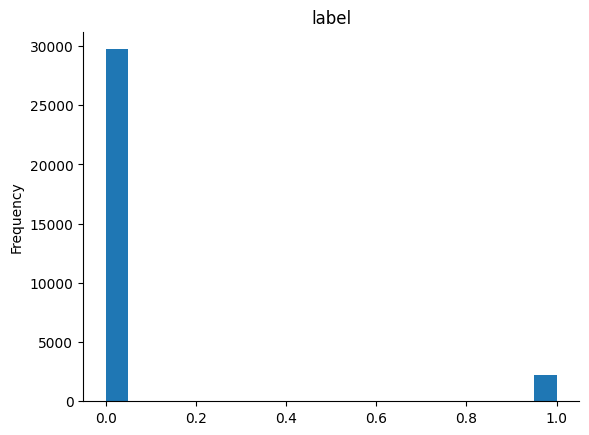

In [3]:
# @title label

from matplotlib import pyplot as plt
TwitterHate['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

The dataset came already labeled, there are two major Labels her 0 representing regular speech and 1 representing hateful language. Now we will simply work on processing this data into a format which the computer can understand and predict.
First, I will be defining a function in python which cleans the document from URLS, "@"'s, "#"'s, delimiters, whitespaces, and any other frequently used twitter symbols.

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'\d+', '', text)      # Remove digits
    text = re.sub(r'\W', ' ', text)      # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)     # Remove extra spaces
    text = text.strip().lower()          # Remove trailing spaces and lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

TwitterHate['cleaned_tweets'] = TwitterHate['tweet'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
TwitterHate.tail()

,id,label,tweet,cleaned_tweets
31957,31958,0,ate @user isz that youuu?ðððððð...,ate isz youuu ð ð ð ð ð ð ð ð ð â ï
31958,31959,0,to see nina turner on the airwaves trying to...,see nina turner airwaves trying wrap mantle ge...
31959,31960,0,listening to sad songs on a monday morning otw...,listening sad songs monday morning otw work sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...",vandalised condemns act
31961,31962,0,thank you @user for you follow,thank follow


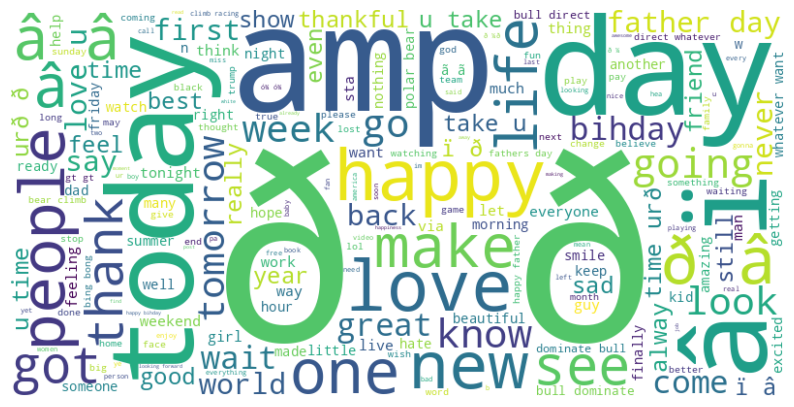

In [24]:
# Create and display a word cloud
all_words = ' '.join([text for text in TwitterHate['cleaned_tweets']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

I noticed from the previous Demonstration that the label column which is the target column for prediction is imbalanced let us investigate further into this before proceeding to modelling the data.

In [6]:
from collections import Counter
#Check the distribution of the Label column in from the orignal dataset
print(f"Original dataset shape: {Counter(TwitterHate['label'])}")

Original dataset shape: Counter({0: 29720, 1: 2242})


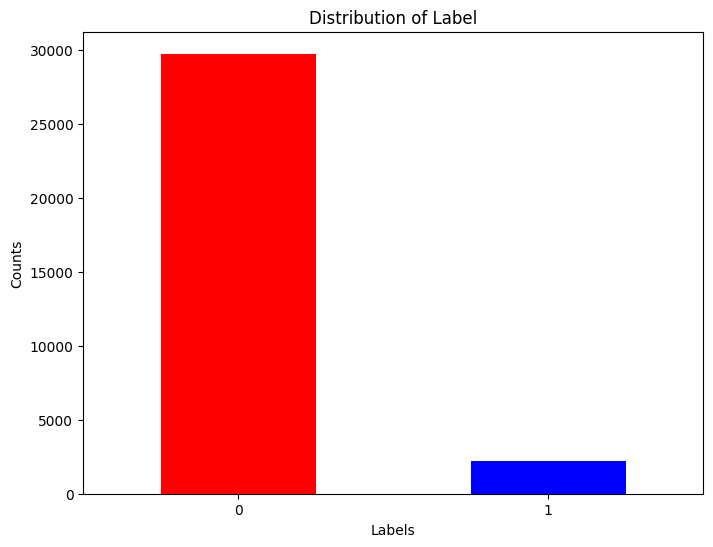

In [7]:
#Visualizing the distribution of the Label column
Label_counts = TwitterHate['label'].value_counts()

plt.figure(figsize=(8, 6))
Label_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Label')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()


Clearly this dataset is imbalance and can affect the outcome of our prediction. Before proceding I will normalize this dataset to ensure that the data is balanced and fit for training. To Normalize the dataset we will be following a couple of steps
1. Vectorize the text data ( This means to convert the data into numbers which can be easily understood by the data)
2. Split the dataset into training and test data set
3. Implement a hyperparameter that "punishes" the skewed outcome in the train dataset, so that the weaker outcome has a fair chance of being included into the model.



In [8]:
from imblearn.over_sampling import RandomOverSampler
X = TwitterHate['cleaned_tweets']
y = TwitterHate['label']

# Vectorizing the text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tfidf, y)

In [9]:
# New distribution
print(f"Resampled dataset shape: {Counter(y_resampled)}")


Resampled dataset shape: Counter({0: 29720, 1: 29720})


Now we can split the data into train and test dataset for modelling

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Instantiate and fit the Logistic Regression model to the train dataset

In [17]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

From the fitted model we can now make predictions on what the output of the train dataset will look like and how the algorithim will label such words in its predictions.

In [20]:
test_predictions = model.predict(X_test)

#Evaluation

To evaluate the performance of the model I will be using 4 major criteria of measurement
1. Accuracy: this represents how many instances are predicted correctly
2. Confusion_matrix: This predicts how many true predictions are in comparision to the false predictions of the model
3. Area Under the Curve: This represents a plot of the true positive rate against the false positive rate.
4. Classification score report:



In [28]:
# Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

accuracy = accuracy_score(y_test, test_predictions)
conf_matrix = confusion_matrix(y_test, test_predictions)
class_report = classification_report(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.9226110363391655
Confusion Matrix:
[[5339  553]
 [ 367 5629]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      5892
           1       0.91      0.94      0.92      5996

    accuracy                           0.92     11888
   macro avg       0.92      0.92      0.92     11888
weighted avg       0.92      0.92      0.92     11888

ROC AUC Score: 0.9695479974882553


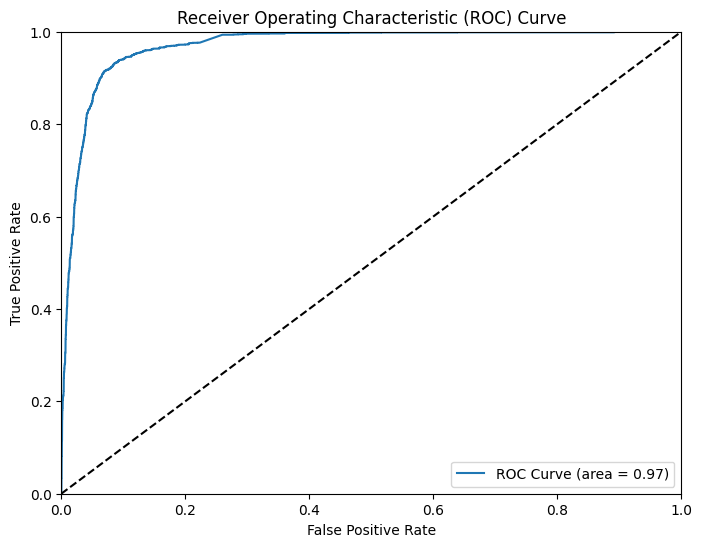

In [27]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()